In [1]:
from importlib import reload
import src.data
import src.graph_utils
import src.cascade_failure
import src.visualization
import src.atack
reload(src.cascade_failure)
reload(src.data)
reload(src.graph_utils)
reload(src.visualization)
reload(src.atack)

from src.data import load_data
from src.graph_utils import assign_attributes
from src.cascade_failure import cascade_failure_DC
from src.visualization import draw_graph_after_failure
from src.atack import random_node_attack, high_capacity_node_attack, random_generator_node_attack, high_capacity_high_voltage_node_attack


In [2]:
G = load_data()
G = assign_attributes(G)

Graph loaded: 4941 nodes, 6594 edges


# DC model

### No overloaded edges

Iterations: 8
0 overloaded: 788
1 overloaded: 717
2 overloaded: 231
3 overloaded: 60
4 overloaded: 27
5 overloaded: 15
6 overloaded: 6
7 overloaded: 0


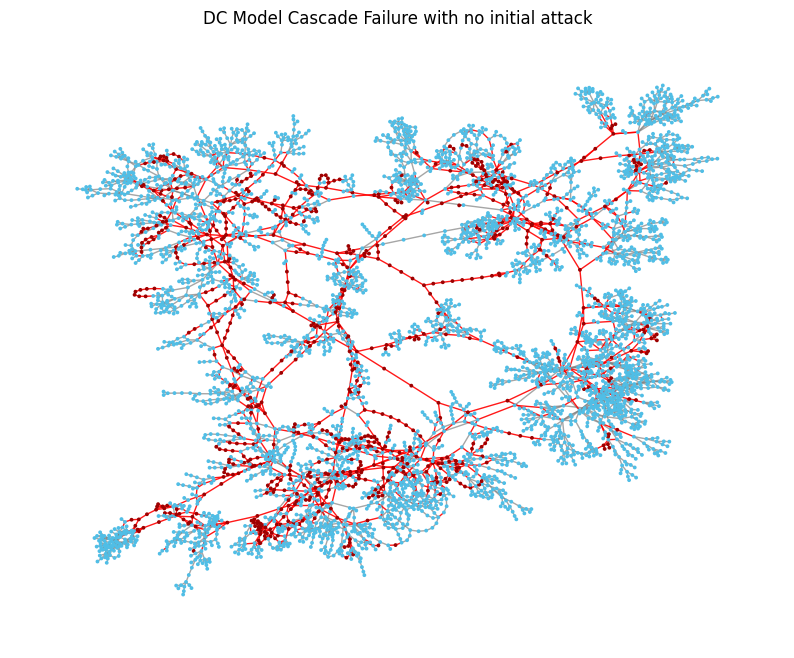

In [3]:
result_after_attack = cascade_failure_DC(G0=G)

print("Iterations:", len(result_after_attack['history']))
for h in result_after_attack['history']:
    print(h['iteration'], "overloaded:", h['overloaded_count'])

failed_edges = []
for step in result_after_attack['history']:
    failed_edges.extend(step['overloaded_edges'])

draw_graph_after_failure(G_before=G, G_after=result_after_attack['graph'], failed_edges=failed_edges, title="DC Model Cascade Failure with no initial attack")

In [4]:
total_load = sum(G.nodes[n]['load_MW'] for n in G.nodes())
total_gen = sum(G.nodes[n]['gen_MW'] for n in G.nodes())
print(total_load, total_gen)

197880.0 169766.93141776646


In [2]:
import pandapower as pp
import pandas as pd
import numpy as np
import ast

# -----------------------------
# 1. Load CSV data
# -----------------------------
nodes = pd.read_csv("data/nodes.csv")
edges = pd.read_csv("data/edges.csv")

# Convert string positions to tuples
nodes["pos"] = nodes["pos"].apply(
    lambda x: tuple(ast.literal_eval(x.replace("array","").replace("[","(").replace("]",")")))
)

# -----------------------------
# 2. Create empty pandapower network
# -----------------------------
net = pp.create_empty_network()
bus_map = {}
default_vn_kv = 110

# -----------------------------
# 3. Create buses
# -----------------------------
for _, row in nodes.iterrows():
    bus_idx = pp.create_bus(net, vn_kv=default_vn_kv, geodata=row["pos"])
    bus_map[row["index"]] = bus_idx

# -----------------------------
# 4. Create lines with realistic lengths
# -----------------------------
scale_factor = 0.001  # convert meters to km, adjust based on coordinate units
default_std_type = "149-AL1/24-ST1A 110.0"  # 110 kV, ~300 MW rating

for _, row in edges.iterrows():
    b1, b2 = bus_map[row["source"]], bus_map[row["target"]]
    x1, y1 = nodes.loc[nodes["index"]==row["source"], "pos"].iloc[0]
    x2, y2 = nodes.loc[nodes["index"]==row["target"], "pos"].iloc[0]

    length_km = max(np.sqrt((x2-x1)**2 + (y2-y1)**2) * scale_factor, 0.1)
    pp.create_line(net, from_bus=b1, to_bus=b2, length_km=length_km, std_type=default_std_type)

# -----------------------------
# 5. Assign scaled loads
# -----------------------------
np.random.seed(42)
for b in net.bus.index:
    # Scale loads to 50–200 kW per bus (~0.05–0.2 MW) for stability
    pp.create_load(net, bus=b, p_mw=np.random.uniform(0.1, 0.25), q_mvar=0.0)

# -----------------------------
# 6. Assign generators (distributed)
# -----------------------------
buses = list(net.bus.index)
gen_buses = np.random.choice(buses, size=max(1,len(buses)//5), replace=False)
slack_bus = gen_buses[0]

# Ext grid for slack bus
pp.create_ext_grid(net, bus=slack_bus, vm_pu=1.0)

# Small distributed generators
for b in gen_buses:
    if b != slack_bus:
        pp.create_gen(net, bus=b, p_mw=np.random.uniform(0.1, 0.25), slack=False)

# -----------------------------
# 7. Run DC power flow (base case)
# -----------------------------
net_copy = pp.copy.deepcopy(net)
pp.rundcpp(net)
max_loading = net.res_line.loading_percent.max()
print("Base case max line loading (%):", max_loading)

print("Number of lines:", len(net.line))
print("Number of lines:", len(net_copy.line))
      

if max_loading > 100:
    print("Warning: Base case is overloaded! Adjust scaling or line types.")
else:
    print("Base case is stable. Ready for cascade simulation.")

# -----------------------------
# 8. Cascade simulation function
# -----------------------------
def run_cascade(net, initial_line_outages, overload_factor=1.2):
    """
    Deterministic cascading failure:
    - Remove initial outages
    - Recalculate DC power flow
    - Remove any line with loading > overload_factor * 100%
    - Repeat until stable
    """
    failed = set(initial_line_outages)
    newly_failed = True

    while newly_failed:
        newly_failed = []

        # Remove failed lines using .loc to avoid pandas warning
        for l in failed:
            if net.line.loc[l, "in_service"]:
                net.line.loc[l, "in_service"] = False

        # Run DC power flow
        try:
            pp.rundcpp(net)
        except:
            print("Island unsolvable -> cascade collapse.")
            return failed

        # Check overloaded lines
        for l in net.line.index:
            if not net.line.loc[l, "in_service"]:
                continue
            loading = net.res_line.loc[l, "loading_percent"]
            if loading > overload_factor * 100:
                newly_failed.append(l)

        failed.update(newly_failed)

    return failed


Base case max line loading (%): 770.9544267057312
Number of lines: 6594
Number of lines: 6594


In [3]:
# Threshold for overload: 100%
overload_threshold = 100.0

# Boolean mask: True if line is overloaded
overloaded_mask = net.res_line.loading_percent > overload_threshold

# Count
num_overloaded = overloaded_mask.sum()
print(f"Number of overloaded lines: {num_overloaded}")

# Optionally, get their indices
overloaded_lines = net.res_line.index[overloaded_mask].tolist()
print("Overloaded line indices:", overloaded_lines)

print("Number of lines:", len(net.line))

Number of overloaded lines: 12
Overloaded line indices: [3268, 5432, 5433, 5449, 5451, 5472, 5547, 5549, 5556, 5558, 5583, 5585]
Number of lines: 6594


In [15]:
N = 100  # number of lines to remove
np.random.seed(42)  # for reproducibility

# Choose N random line indices from the network
all_lines = net.line.index.tolist()
initial_outages = np.random.choice(all_lines, size=N, replace=False).tolist()

print("Random initial outages:", initial_outages)

# Run cascade
failed_lines = run_cascade(net, initial_outages)
print("Lines failed during cascade:", failed_lines)
print("Total lines failed:", len(failed_lines))

Random initial outages: [2770, 5897, 4310, 503, 5435, 1872, 4409, 534, 5333, 3409, 2523, 5485, 6260, 3656, 393, 5764, 1446, 96, 3469, 1730, 5368, 3032, 1840, 4738, 6576, 1357, 6351, 469, 217, 5551, 2398, 1315, 4864, 5470, 4994, 2787, 3065, 6257, 4152, 2868, 1973, 1765, 4078, 4129, 5089, 1340, 1057, 5638, 6208, 17, 4486, 1158, 4815, 3347, 5938, 2515, 1406, 5120, 3429, 2885, 1339, 2345, 3488, 3039, 5971, 811, 1695, 476, 1499, 5681, 5886, 2303, 4392, 764, 6485, 263, 5891, 3937, 3441, 2718, 3739, 1221, 3745, 4354, 1807, 2707, 4110, 3536, 4918, 5351, 4288, 3231, 2402, 6344, 1867, 1862, 4739, 1420, 5430, 3442]
Lines failed during cascade: {5120, 5638, 4110, 17, 534, 4129, 1057, 5681, 4152, 6208, 3656, 96, 6257, 6260, 4738, 4739, 5764, 1158, 2707, 3739, 2718, 1695, 3231, 3745, 4288, 1730, 1221, 6344, 6351, 4815, 2770, 5333, 4310, 217, 2787, 1765, 5351, 5368, 764, 5886, 2303, 4864, 4354, 5891, 263, 5897, 1807, 3347, 1315, 4392, 2345, 811, 1840, 5938, 2868, 4918, 5430, 5432, 4409, 5433, 5435, 1